# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [4]:
import numpy as np
import os
# from scipy.misc.pilutil import imread, imresize
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [6]:
import os
os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from keras import backend as K

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [8]:
train_doc, val_doc = get_data('datasets/Project_data/', ablation=None)
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [48]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size,  is_train = False, augmention = False, debug=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = 30 #create a list of image numbers you want to use for a particular video
    # count = 0
    while True:
#         t = np.random.permutation(folder_list)
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
        if len(train_doc)%batch_size == 0:
            num_batches = len(train_doc)//batch_size # calculate the number of batches number of sequences/batchsize 663/10 = 66, 3 rem
        else:
            num_batches = len(train_doc)//batch_size + 1
        for batch in range(num_batches): # we iterate over the number of batches
            x = img_idx
            y=120
            z=120
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
#                 print ("batch, video", batch, folder + (batch*batch_size))
                if folder + (batch*batch_size) >= len(t):
#                     print("Breaking")
                    break
                # print(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                # print(type(imgs))
                # print(imgs)
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(range(img_idx)): #  Iterate iver the frames/images of a folder to read them in
                    # print(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image_array = np.array(image)
                    # print("image array before shape", image_array.shape)
                    # print("image array before", image_array)
                    if image_array.shape[1] > image_array.shape[0]:
                        diff_px = image_array.shape[1] - image_array.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image_array.shape[0]
                        image_array = image_array[:, crop_start:crop_end]
                    elif image_array.shape[0] > image_array.shape[1]:
                        diff_px = image_array.shape[0] - image_array.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image_array.shape[1]
                        image_array = image_array[:, crop_start:crop_end]
                    # print("image array after shape", image_array.shape)
                    image = Image.fromarray(image_array)
                    img_resized = image.resize((y, z))
                    
#                     if aug_type is not None:
#                         if aug_type == 0: # edge Enhancement
#                             resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
#                         elif aug_type == 1: # adding gaussian blur
#                             resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
#                         elif aug_type == 2: # enchancing image detailing
#                             resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
#                         elif aug_type == 3: # sharpening image
#                             resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
#                         elif aug_type == 4: # Brightness enhancement
#                             resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    image_array = np.array(img_resized)
                    # print("image size: ", image_array[:,:,0].shape)
                    # plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
                    # plt.imshow(Image.fromarray(image_array))
                    batch_data[folder,idx,:,:,0] = image_array[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image_array[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image_array[:,:,2]/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            # print(batch_labels)
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            # count = count + 1
                

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path =  'datasets/Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [14]:
# testing generative 
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[0]

Source path =  datasets/Project_data/train ; batch size = 1
batch, video 0 0


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [30]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

### Experiment - 1 & 2
**Conv3D**

In [31]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

### Experiment - 3
**Conv3D**

In [32]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(3, 2, 2)))

# model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(5, activation='softmax'))

### Experiment - 4
**Conv3D**

In [33]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(5, activation='softmax'))

### Experiment - 5 & 6
**Conv3D**

In [34]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 7 & 8
**Conv3D**

In [35]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# #model.add(Dropout(0.2))
# model.add(Dropout(0.5))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# #model.add(Dropout(0.2))
# model.add(Dropout(0.5))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# #model.add(Dropout(0.2))
# model.add(Dropout(0.5))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# #model.add(Dropout(0.2))
# model.add(Dropout(0.5))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 9
**Conv3D**

In [36]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 10
**Conv3D**

In [37]:
# loss: 0.1388 - categorical_accuracy: 0.9539 - val_loss: 0.1661 - val_categorical_accuracy: 0.9297
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GlobalAveragePooling3D())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 11
**TimeDistributed Conv2D + GRU**

In [38]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 12
**TimeDistributed Conv2D + GRU**

In [39]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 13
**TimeDistributed Conv2D + Dense**

In [40]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(128, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(GlobalAveragePooling3D())
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 14
**TimeDistributed + ConvLSTM2D**

In [41]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Conv2D(16, (3,3), activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(
#     ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Dense(64, activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax'))

# Final Model

In [54]:
input_shape = (30,120,120,3)
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [55]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 30, 118, 118, 8)  224       
 tributed)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 30, 118, 118, 8)  32        
 hNormalization)                                                 
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 30, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 114, 114, 8)      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [56]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [57]:
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [58]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [59]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.4911 - categorical_accuracy: 0.3333Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_exp_16_2024-07-3115_54_19.220716/model-00001-1.49106-0.33333-1.25565-0.14062.h5
21/21 [==============================] - 73s 3s/step - loss: 1.4911 - categorical_accuracy: 0.3333 - val_loss: 1.2556 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.3103 - categorical_accuracy: 0.4658
Epoch 00002: saving model to model_init_exp_16_2024-07-3115_54_19.220716/model-00002-1.31029-0.46577-0.00000-0.00000.h5
21/21 [==============================] - 60s 3s/step - loss: 1.3103 - categorical_accuracy: 0.4658 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.1683 - categorical

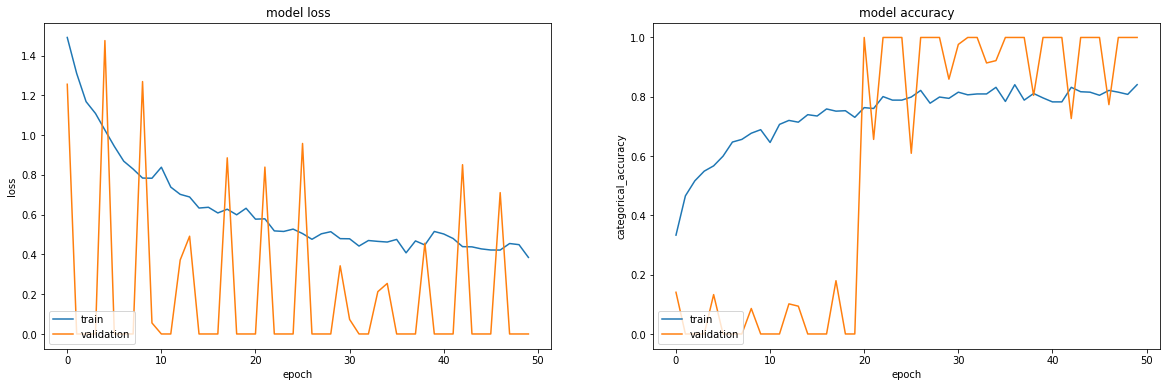

In [60]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')